In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt

# machine learning packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# nlp packages
!pip install -q --upgrade transformers
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, DataCollatorWithPadding, TrainingArguments
from datasets import Dataset
transformers.logging.set_verbosity_info()

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 83.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.0 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.


2025-10-23 01:11:13.813799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761181874.099312      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761181874.193258      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# check python package versions

print('numpy version is: {}'.format(np.__version__))
print('pandas version is: {}'.format(pd.__version__))
print('matplotlib version is: {}'.format(matplotlib.__version__))
print('scikit-learn version is: {}'.format(sklearn.__version__))
print('transformers version is: {}'.format(transformers.__version__))

numpy version is: 1.26.4
pandas version is: 2.2.3
matplotlib version is: 3.7.2
scikit-learn version is: 1.2.2
transformers version is: 4.57.1


In [3]:
# load in the training data
train_df= pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

# look at first 5 rows
print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [4]:
# check nulls and column types for training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<BarContainer object of 2 artists>

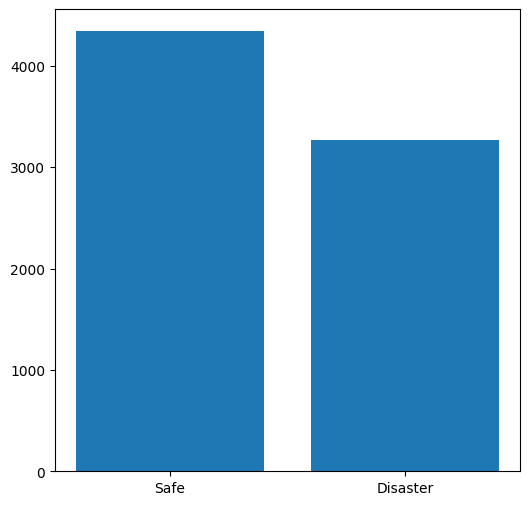

In [5]:
# look at the training target
count1= train_df['target'].value_counts()
label1= [0, 1]

# visualize label distribution
fig1= plt.figure(figsize= (6, 6))
ax1= plt.gca()
ax1.bar(['Safe', 'Disaster'], count1.values.tolist())

Dataset is balanced.

In [6]:
# load in the test data
test_df= pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# look at first 5 rows of test dataframe
print(test_df.head())

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# remove extra columns
train1= train_df.loc[:, ['text', 'target']]
train1.columns= ['text', 'label']
test_id= test_df.loc[:, 'id'].to_frame()
test1= test_df.loc[:, 'text'].to_frame()

# look at new training dataframe
print('training data')
print(train1.head())
print(train1.shape)

# look at test id series
print('-'*80)
print('test id')
print(test_id.head())

# look at new test dataframe
print('-'*80)
print('test data')
print(test1.head())
print(test1.shape)

training data
                                                text  label
0  Our Deeds are the Reason of this #earthquake M...      1
1             Forest fire near La Ronge Sask. Canada      1
2  All residents asked to 'shelter in place' are ...      1
3  13,000 people receive #wildfires evacuation or...      1
4  Just got sent this photo from Ruby #Alaska as ...      1
(7613, 2)
--------------------------------------------------------------------------------
test id
   id
0   0
1   2
2   3
3   9
4  11
--------------------------------------------------------------------------------
test data
                                                text
0                 Just happened a terrible car crash
1  Heard about #earthquake is different cities, s...
2  there is a forest fire at spot pond, geese are...
3           Apocalypse lighting. #Spokane #wildfires
4      Typhoon Soudelor kills 28 in China and Taiwan
(3263, 1)


In [8]:
# split training into training and validation

train2, val2= train_test_split(train1, test_size= 0.2, shuffle= True, random_state= 24)

# reset index for training and test
train2.reset_index(drop= True, inplace= True)
val2.reset_index(drop= True, inplace= True)

# look at training dataframe after split
print('training data')
print(train2.head())
print(train2.shape)

# look at validation dataframe
print('\n validation data')
print(val2.head())
print(val2.shape)

training data
                                                text  label
0  @cnni @PrisonPlanet Climate Change CNN weather...      1
1  Refugee Connections Indiegogo campaign will be...      1
2  Want to work in #Tarzana CA? View our latest o...      0
3  Slow clap for this pilot. Dramatic Video Shows...      1
4  Learn How I Gained Access To The Secrets Of Th...      0
(6090, 2)

 validation data
                                                text  label
0  Kids got Disney version of the game Operation ...      0
1  UPDATE: Indiana State Police reopening I-65 ne...      1
2  God forbid anyone in my family knows how to an...      0
3  First wreck today. So so glad me and mom are o...      0
4  Exploration takes seismic shift in Gabon to So...      0
(1523, 2)


In [9]:
# convert from dataframe to dataset

# training
train_data= Dataset.from_pandas(train2)
print('training')
print(train_data.features)

# validation
val_data= Dataset.from_pandas(val2)
print('validation')
print(val_data.features)

# test
test_data= Dataset.from_pandas(test1)
print('test')
print(test_data.features)

training
{'text': Value('string'), 'label': Value('int64')}
validation
{'text': Value('string'), 'label': Value('int64')}
test
{'text': Value('string')}


In [10]:
# model distilbert
dbert= 'distilbert/distilbert-base-uncased'

# initialize model tokenizer
tokenizer= AutoTokenizer.from_pretrained(dbert)

id2label= {0: 'safe', 1:'disaster'}
label2id= {'safe':0, 'disaster':1}

# setup model
model= AutoModelForSequenceClassification.from_pretrained(dbert, num_labels= 2, 
                                                          id2label= id2label, label2id= label2id)

# freeze model layers (not classification head)
for name, param in model.named_parameters():
    if 'distilbert' in name:
        param.requires_grad= False



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.1",
  "vocab_size": 30522
}



vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
 

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Some weights of the model checkpoint at distilbert/distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertFor

In [11]:
# tokenize datasets

# tokenize function
def token_fn(sentence1):
    return tokenizer(sentence1['text'], truncation= True)

# tokenize training
train_token= train_data.map(token_fn, batched= True)


# tokenize validation
val_token= val_data.map(token_fn, batched= True)


# tokenize test
test_token= test_data.map(token_fn, batched= True)

# look at training tokenized
print('training tokenized')
print(train_token.features)

# look at validation tokenized
print('validation tokenized')
print(val_token.features)

# look at test tokenized
print('test tokenized')
print(test_token.features)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

training tokenized
{'text': Value('string'), 'label': Value('int64'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}
validation tokenized
{'text': Value('string'), 'label': Value('int64'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}
test tokenized
{'text': Value('string'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}


In [12]:
# data collator to pad the batches
collator= DataCollatorWithPadding(tokenizer= tokenizer)

In [13]:
# function to compute metrics

def metric_fn(eval_preds):
    # extract prediction and labels
    preds, labels= eval_preds
    # get prediction
    y_pred= np.argmax(preds, axis= 1)
    # accuracy score
    acc1= accuracy_score(labels, y_pred)
    # f1 score
    f1= f1_score(labels, y_pred)
    print('accuracy is:{} and f1 score is:{}'.format(acc1, f1))
    return {'accuracy': acc1, 'f1':f1}

In [14]:
# training arguments
# learning rate
rate1= 5e-4
# batch size
batch1= 10
# num epochs
epoch1= 10

training_args= TrainingArguments(output_dir= '/kaggle/working/', 
                                learning_rate= rate1, 
                                report_to= 'none',
                                per_device_train_batch_size= batch1,
                                per_device_eval_batch_size= batch1,
                                num_train_epochs= epoch1,
                                weight_decay= 0.1,
                                metric_for_best_model= 'f1',
                                logging_strategy= 'epoch', 
                                fp16= True,
                                eval_strategy= 'epoch', 
                                save_strategy= 'epoch',
                                load_best_model_at_end= True) 


PyTorch: setting up devices


In [15]:
# setup trainer

trainer= Trainer(model= model, args= training_args, train_dataset= train_token, 
                 eval_dataset= val_token, tokenizer= tokenizer, data_collator= collator, 
                 compute_metrics= metric_fn)

trainer.train()

Using auto half precision backend
The following columns in the Training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6,090
  Num Epochs = 10
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 6,090
  Number of trainable parameters = 592,130


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.471500,0.456822,0.805647,0.732369
2,0.453300,0.410743,0.819435,0.771405
3,0.435600,0.414689,0.826658,0.786753
4,0.429400,0.409596,0.820092,0.780096
5,0.424700,0.464050,0.780696,0.764124
6,0.415300,0.410657,0.822718,0.781906
7,0.407300,0.408754,0.827315,0.777684
8,0.398100,0.407658,0.825345,0.772260
9,0.397700,0.408043,0.826658,0.785016
10,0.390700,0.407183,0.827315,0.787732


The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8056467498358503 and f1 score is:0.7323688969258589


Saving model checkpoint to /kaggle/working/checkpoint-609
Configuration saved in /kaggle/working/checkpoint-609/config.json
Model weights saved in /kaggle/working/checkpoint-609/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-609/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-609/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8194353250164149 and f1 score is:0.771404821280133


Saving model checkpoint to /kaggle/working/checkpoint-1218
Configuration saved in /kaggle/working/checkpoint-1218/config.json
Model weights saved in /kaggle/working/checkpoint-1218/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-1218/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-1218/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8266579120157583 and f1 score is:0.7867528271405493


Saving model checkpoint to /kaggle/working/checkpoint-1827
Configuration saved in /kaggle/working/checkpoint-1827/config.json
Model weights saved in /kaggle/working/checkpoint-1827/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-1827/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-1827/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8200919238345371 and f1 score is:0.7800963081861958


Saving model checkpoint to /kaggle/working/checkpoint-2436
Configuration saved in /kaggle/working/checkpoint-2436/config.json
Model weights saved in /kaggle/working/checkpoint-2436/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-2436/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-2436/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.7806959947472094 and f1 score is:0.7641242937853108


Saving model checkpoint to /kaggle/working/checkpoint-3045
Configuration saved in /kaggle/working/checkpoint-3045/config.json
Model weights saved in /kaggle/working/checkpoint-3045/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-3045/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-3045/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8227183191070256 and f1 score is:0.7819063004846526


Saving model checkpoint to /kaggle/working/checkpoint-3654
Configuration saved in /kaggle/working/checkpoint-3654/config.json
Model weights saved in /kaggle/working/checkpoint-3654/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-3654/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-3654/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8273145108338805 and f1 score is:0.7776838546069316


Saving model checkpoint to /kaggle/working/checkpoint-4263
Configuration saved in /kaggle/working/checkpoint-4263/config.json
Model weights saved in /kaggle/working/checkpoint-4263/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-4263/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-4263/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8253447143795141 and f1 score is:0.7722602739726027


Saving model checkpoint to /kaggle/working/checkpoint-4872
Configuration saved in /kaggle/working/checkpoint-4872/config.json
Model weights saved in /kaggle/working/checkpoint-4872/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-4872/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-4872/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8266579120157583 and f1 score is:0.785016286644951


Saving model checkpoint to /kaggle/working/checkpoint-5481
Configuration saved in /kaggle/working/checkpoint-5481/config.json
Model weights saved in /kaggle/working/checkpoint-5481/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-5481/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-5481/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 10


accuracy is:0.8273145108338805 and f1 score is:0.7877320419693301


Saving model checkpoint to /kaggle/working/checkpoint-6090
Configuration saved in /kaggle/working/checkpoint-6090/config.json
Model weights saved in /kaggle/working/checkpoint-6090/model.safetensors
tokenizer config file saved in /kaggle/working/checkpoint-6090/tokenizer_config.json
Special tokens file saved in /kaggle/working/checkpoint-6090/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /kaggle/working/checkpoint-6090 (score: 0.7877320419693301).


TrainOutput(global_step=6090, training_loss=0.42236725003848524, metrics={'train_runtime': 3138.3075, 'train_samples_per_second': 19.405, 'train_steps_per_second': 1.941, 'total_flos': 809851860502080.0, 'train_loss': 0.42236725003848524, 'epoch': 10.0})

Model from epoch 10 had lowest validation loss, this model was chosen for predictions on test data.

In [16]:
# use the model above for prediction on test

# model with lowest validation loss
saved_model1= '/kaggle/working/checkpoint-6090/'

model1= AutoModelForSequenceClassification.from_pretrained(saved_model1)

test_args= TrainingArguments(output_dir= '/kaggle/working/', 
                                report_to= 'none',
                                per_device_eval_batch_size= batch1,
                                do_train= False, 
                                do_predict= True) 



loading configuration file /kaggle/working/checkpoint-6090/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "safe",
    "1": "disaster"
  },
  "initializer_range": 0.02,
  "label2id": {
    "disaster": 1,
    "safe": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.1",
  "vocab_size": 30522
}

loading weights file /kaggle/working/checkpoint-6090/model.safetensors
PyTorch: setting up devices


In [17]:
# trainer for batched inference

# trainer to make predictions on batched test data
trainer1= Trainer(model= model1, args= test_args, data_collator= collator)

# get prediction results
results= trainer1.predict(test_token)
# get predicted labels
logits= results.predictions
y_test_pred1= np.argmax(logits, axis= 1)
labels= results.label_ids

# make dataframe for submission file
y_test_pred= pd.Series(y_test_pred1, name= 'target')
y_test= pd.concat([test_id, y_test_pred], axis= 1)

# look at first 5 predictions
print('test df')
print(y_test.head())

# submit file to competition
sub_df= y_test.to_csv("/kaggle/working/submission.csv")


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 3263
  Batch size = 10


test df
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
